## EDA for H&M dataset  

Reference Notebook Link: https://www.kaggle.com/vanguarde/h-m-eda-first-look/notebook  

The dataset comprises of 5 segregations, please find the details below:  
1. images: This folder consists of images for most of the articles that are being sold in H&M however all articls don't have respective images.  
2. articles.csv: This csv file consists of metadata for each of the article which are getting sold under H&M banner. It has total 25 columns for each article including metadata information such as product type, product name, product description, etc.  
3. customers.csv: This csv file consists of metadata for each customer id. It has total 7 columns and includes general information regarding a speicific customer such as H&M club member status, age, etc.  
4. transactions_train.csv: This csv file consists of transaction information of any specific article id which any of the customer id has purchased and at what price point the transactions were made and also when was the transaction made.  
5. sample_submission.csv: This csv files consists of customer ids for which the predictions are to be made as to what are the list of article ids that a specific customer id will purchase within a span of one week i.e. 7 days after the training date ends.

In [1]:
# Importing Libraries
import re
import string
import spacy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
articles_data = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")
customers_data = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions_data = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

## Exploring Articles Metadata

In [ ]:
# List all columns present in article metadata
articles_data.columns

In [ ]:
articles_data.head()

In [ ]:
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.histplot(data=articles_data, y='index_name', color='blue')
ax.set_xlabel('count by index name')
ax.set_ylabel('index name')
plt.show()

From the above horizontal bar graph, its easily visible that out of 10 categories of products, the count of ladieswear articles is the highest in the metadata and is more than 25000 in number followed by Divided, Menswear, etc.

In [ ]:
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.histplot(data=articles_data, y='garment_group_name', color='orange', hue='index_group_name', multiple="stack")
ax.set_xlabel('count by garment group')
ax.set_ylabel('garment group')
plt.show()

The garments grouped by index: Jersey fancy is the most frequent garment, especially for women and baby/children. The next by number is accessories which is followed by Jersey Basic, Under-nightwear, etc

Lets look up to the combination counts for index group name and index name

In [ ]:
articles_data.groupby(['index_group_name', 'index_name']).count()['article_id']

Lets look up to the combination counts for product group name and product name

In [ ]:
pd.options.display.max_rows = None
articles_data.groupby(['product_group_name', 'product_type_name']).count()['article_id']

In [ ]:
# Extract number of unique columns values under each column
for col_name in articles_data.columns:
    un_n = articles_data[col_name].nunique()
    print(f'No of unique {col_name}: {un_n}')

## Exploring Textual description of articles

### Steps inolved:
#### Preprocessing Steps:
1. Check missing values and remove them
2. Expand Contractions
3. Lowercase the descriptions
4. Remove digits and words containing digits 
5. Remove punctuations

#### EDA for Textual Description:
1. Stopwords Removal  
2. Lemmatization  
3. Creating Document Matrix

In [ ]:
articles_desc_data = articles_data[['article_id','detail_desc']]

### Preprocessing Steps

#### 1. Check missing values and remove them


In [ ]:
# Counting number of null detailed descriptions for articles
articles_desc_data.isnull().sum()

In [ ]:
articles_desc_data.dropna(inplace=True)
articles_desc_data.isnull().sum()

In [ ]:
articles_desc_data['detail_desc'].unique()

#### 2. Remove Contractions

In [ ]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

In [ ]:
# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
articles_desc_data['detail_desc']=articles_desc_data['detail_desc'].apply(lambda x:expand_contractions(x))


The expand_contractions function uses regular expressions to map the contractions in the text to their expanded forms from the dictionary. 

#### 3. Lowercase the decriptions

In [ ]:
articles_desc_data['detail_desc_cleaned']=articles_desc_data['detail_desc'].apply(lambda x: x.lower())

#### 4. Remove digits and words containing digits

In [ ]:
articles_desc_data['detail_desc_cleaned']=articles_desc_data['detail_desc_cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

#### 5. Remove punctuations and spaces

In [ ]:
articles_desc_data['detail_desc_cleaned']=articles_desc_data['detail_desc_cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
articles_desc_data['detail_desc_cleaned']=articles_desc_data['detail_desc_cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
articles_desc_data['detail_desc_cleaned'].unique()

### EDA for Textual Description

#### 
1. Stopwords Removal 
2. Lemmatization  
3. Finally, we will utilize word cloud library to represent the data

We will use spacy to remove the stopwords and present the lemma form of toekns in article descriptions

In [ ]:
# Loading english spacy model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

lemmatized_desc_list = [(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))(x) for x in articles_desc_data['detail_desc_cleaned'].unique()]
len(lemmatized_desc_list)

# Lemmatization with stopwords removal
# articles_desc_data['lemmatized'] = articles_desc_data['detail_desc_cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
# articles_desc_data.head(10)

In [ ]:
lemmatized_desc_list[:5]

In [ ]:
# Extracting only unique cleaned and lemmatized description for fitting it to Document Term Matrix
print('Shape of overall articles dataframe: %s' %(str(articles_desc_data.shape[0])))
print('Total no of unique article descriptions: %s' %(len(lemmatized_desc_list)))

In [ ]:
# Creating Document Term Matrix
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(lemmatized_desc_list)
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index = lemmatized_desc_list
df_dtm.shape

In [ ]:
df_dtm.head(3)

In [ ]:
# Function for generating word clouds
def generate_wordcloud(data,title):
#     wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
    wc = WordCloud(width=1000, height=330, max_words=150, background_color ='white', min_font_size=4).generate_from_frequencies(data)
    plt.figure(figsize=(15,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(title,60)),fontsize=13)
    plt.show()

In [ ]:
# Transposing document term matrix
df_dtm=df_dtm.transpose()
df_dtm.head(3)

In [ ]:
# Plotting word cloud for each unique first 10 articles
for index,product in enumerate(df_dtm.columns[:10]):
  generate_wordcloud(df_dtm[product].sort_values(ascending=False),product)

From the world clouds above, we can observer that certain words like naroow, shoulder, belt, pocket, jersey, soft, etc are widely being used under descriptions. This proves that most of the article description that H&M uses describes the physical aspects of the article as well as 

In [ ]:
# Clearing out local variables for freeing up RAM
del df_dtm

## Exploring Customer Metadata

In [ ]:
# List all columns present in article metadata
customers_data.columns

In [ ]:
customers_data.head()

In [ ]:
# Counting number of null detailed descriptions for customers
customers_data.isnull().sum()

In [ ]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(15,8))
ax = sns.histplot(data=customers_data, x='age', bins=50, color='blue')
ax.set_xlabel('Distribution of the customers age')
plt.show()

From the above bar plot, its clear that the customer category which shops at H&M are from age range of 21 to 25 which is mostly the early 20s and relevant customers are also seen within age range of 44 to 50. The reasons may be:  
1. Youth styling is better at H&M  
2. Since, dress styles which cater to older category which are mostly subtle in nature are also widely available.

In [ ]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(15,8))
ax = sns.histplot(data=customers_data, x='club_member_status', color='blue')
ax.set_xlabel('Distribution of club member status')
plt.show()

In [ ]:
customers_data.loc[customers_data.club_member_status.isin(['ACTIVE'])].shape[0]/customers_data.shape[0] * 100

Almost 92.7 i.e. 93 % of the customers are active members of H&M.

In [ ]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(15,8))
ax = sns.histplot(data=customers_data, x='fashion_news_frequency', color='blue')
ax.set_xlabel('Distribution of fashion news frequency status')
plt.show()

In [ ]:
customers_data.loc[customers_data.fashion_news_frequency.isin(['NONE','None'])].shape[0]/customers_data.shape[0] * 100

Almost 63.9 i.e. 64 % of the customers receive no communication regrading any latest fashion trends in H&M otherwise they dont agree to receive any notifications for the same

## Exploring Transaction Metadata

In [3]:
# List all columns present in article metadata
transactions_data.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id'], dtype='object')

In [4]:
transactions_data.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [5]:
pd.set_option('display.float_format', '{:.4f}'.format)
transactions_data.describe()

,article_id,price,sales_channel_id
count,31788324.0000,31788324.0000,31788324.0000
mean,696227219.0051,0.0278,1.7040
std,133448003.4874,0.0192,0.4565
min,108775015.0000,0.0000,1.0000
25%,632803008.0000,0.0158,1.0000
50%,714582003.0000,0.0254,2.0000
75%,786524001.0000,0.0339,2.0000
max,956217002.0000,0.5915,2.0000


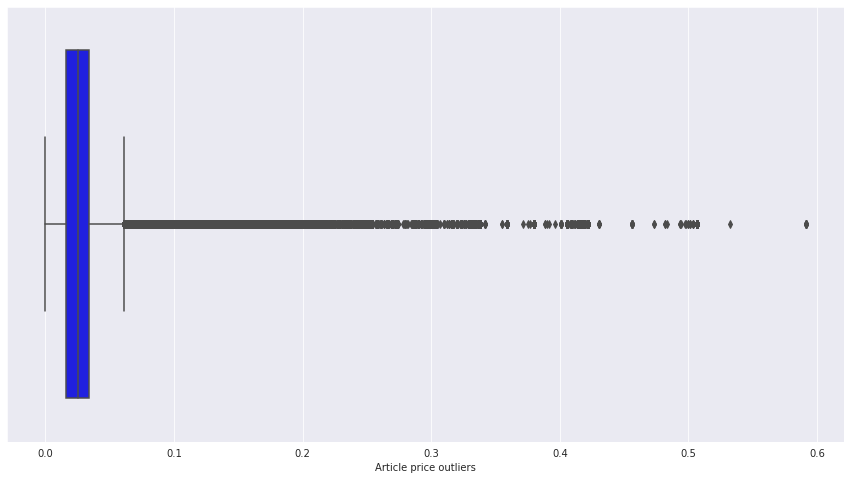

In [6]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(15,8))
ax = sns.boxplot(data=transactions_data, x='price', color='blue')
ax.set_xlabel('Article price outliers')
plt.show()

Finding the best transaction date range with the highest transactions made

In [7]:
transactions_data.groupby(['t_dat']).agg({'price':'sum'}).sort_values('price', ascending=False)[:10]

,price
t_dat,
2019-09-28,6161.6031
2019-11-29,4444.3424
2018-09-29,4071.3813
2020-04-11,3961.9878
2018-11-23,3891.9394
2019-11-28,3103.0279
2019-04-06,3100.9049
2019-11-03,2738.4625
2019-05-16,2593.4873


We can clearly observe that the topmost sells happened during the time of season sale, clearance sale or christmas celebration kind of shopping and the trend could be observed across the data of 3 years 

Top 10 customers based on number of transcation that were made

In [8]:
transactions_data.groupby(['customer_id']).count().sort_values(by='price', ascending=False)['price'][:10]

customer_id
be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b    1895
b4db5e5259234574edfff958e170fe3a5e13b6f146752ca066abca3c156acc71    1441
49beaacac0c7801c2ce2d189efe525fe80b5d37e46ed05b50a4cd88e34d0748f    1364
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc    1361
cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed6012e7e5bea016b4d6    1237
55d15396193dfd45836af3a6269a079efea339e875eff42cc0c228b002548a9d    1208
c140410d72a41ee5e2e3ba3d7f5a860f337f1b5e41c27cf9bda5517c8774f8fa    1170
8df45859ccd71ef1e48e2ee9d1c65d5728c31c46ae957d659fa4e5c3af6cc076    1169
03d0011487606c37c1b1ed147fc72f285a50c05f00b9712e0fc3da400c864296    1157
6cc121e5cc202d2bf344ffe795002bdbf87178054bcda2e57161f0ef810a4b55    1143
Name: price, dtype: int64

### Merge transaction details with articles

In [9]:
articles_data_extract = articles_data[['article_id', 'prod_name', 'product_type_name', 'product_group_name', 'index_name']]

In [10]:
articles_data_extract = transactions_data[['customer_id', 'article_id', 'price', 't_dat']].merge(articles_data_extract, on='article_id', how='left')
articles_data_extract.head()

,customer_id,article_id,price,t_dat,prod_name,product_type_name,product_group_name,index_name
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.0508,2018-09-20,Atlanta Push Body Harlow,Underwear body,Underwear,Lingeries/Tights
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.0305,2018-09-20,Rae Push (Melbourne) 2p,Bra,Underwear,Lingeries/Tights
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.0152,2018-09-20,Inca Jumper,Sweater,Garment Upper body,Divided
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.0169,2018-09-20,W YODA KNIT OL OFFER,Sweater,Garment Upper body,Ladieswear
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.0169,2018-09-20,W YODA KNIT OL OFFER,Sweater,Garment Upper body,Ladieswear


In [11]:
articles_data_extract.shape

(31788324, 8)

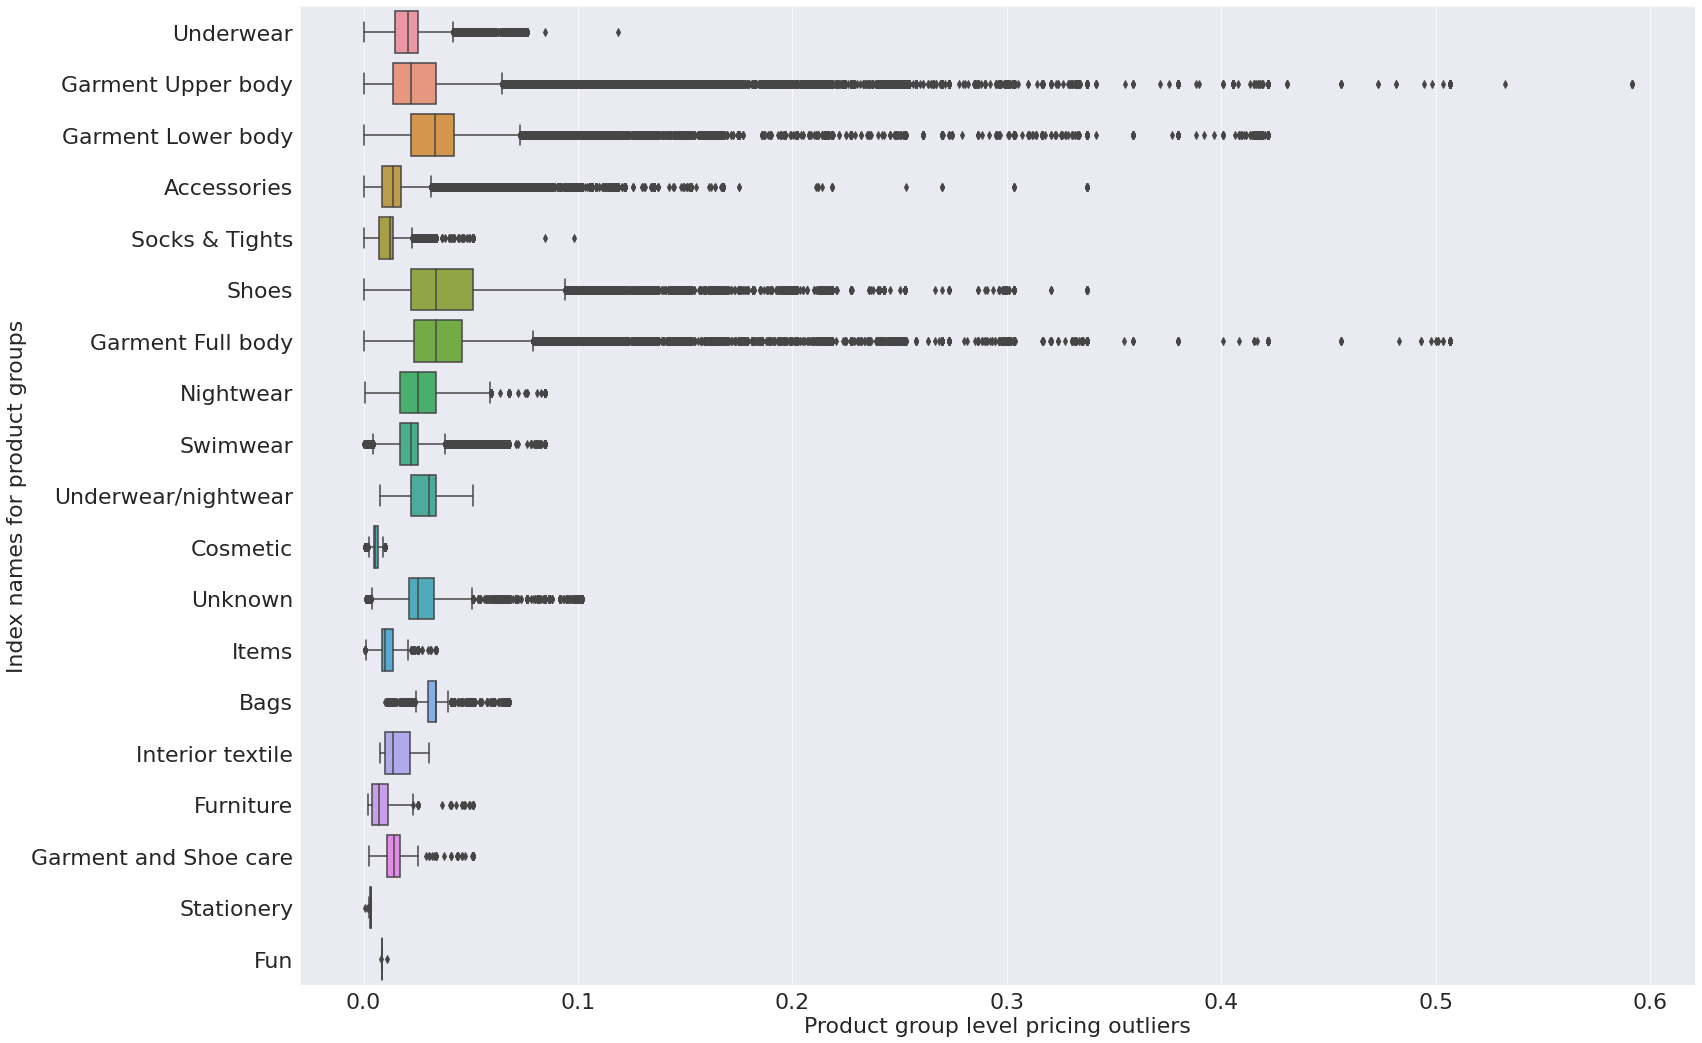

In [12]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(25,18))
ax = sns.boxplot(data=articles_data_extract, x='price', y='product_group_name')
ax.set_xlabel('Product group level pricing outliers', fontsize=22)
ax.set_ylabel('Index names for product groups', fontsize=22)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)
plt.show()

In the above boxplot, we see outliers for group name prices. Lower/Upper/Full body have a huge price variance. I guess it could be like some unique collections, relative to casual ones. Some high price articles even belong to accessories group.

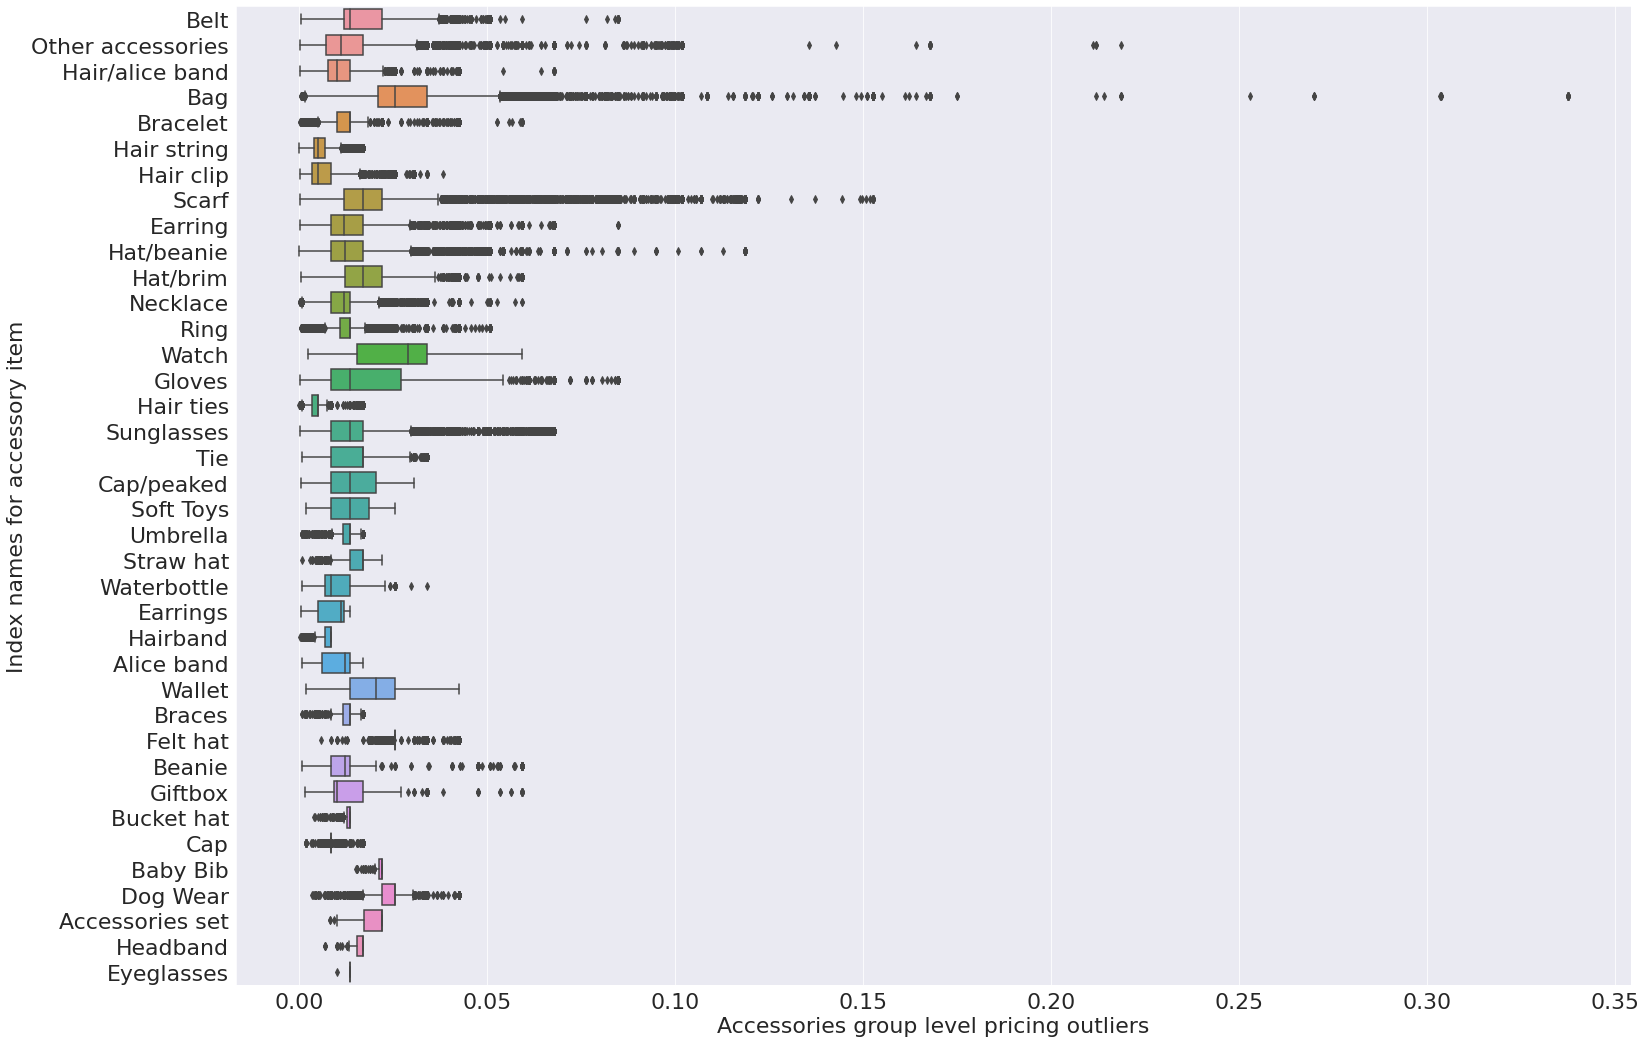

In [14]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(25,18))
_ = articles_data_extract[articles_data_extract['product_group_name'] == 'Accessories']
ax = sns.boxplot(data=_, x='price', y='product_type_name')
ax.set_xlabel('Accessories group level pricing outliers', fontsize=22)
ax.set_ylabel('Index names for accessory item', fontsize=22)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)
del _
plt.show()

Lets look at boxplot prices according to accessories product group and find the reasons of high prices inside this specific group. We can easily observe that the largest outliers can be found among bags, which is logical enough. In addition, scarves and other accessories have articles with prices highly contrasting to the rest of garments.

In [ ]:
articles_index = articles_data_extract[['product_group_name', 'price']].groupby('product_group_name').mean()
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(x=articles_index.price, y=articles_index.index, color='blue', alpha=0.8)
ax.set_xlabel('Price by product group')
ax.set_ylabel('Product group')
plt.show()

From the above bar plot it is clearly visible that we are seeing the means are seen in below mentioned product group names. Top 10 product group names are:  
Shoes  
Garment Full body  
Bags  
Garment Lower body  
Underwear/nightwear  
Swimwear  
Garment and Shoe Care  
Interior textile  
Accessories  
Socks & Tights

In [ ]:
articles_data_extract['t_dat'] = pd.to_datetime(articles_data_extract['t_dat'])

product_list = ['Shoes', 'Garment Full body', 'Bags', 'Garment Lower body', 'Underwear/nightwear','Swimwear','Garment and Shoe Care','Interior textile','Accessories','Socks & Tights']
colors = ['cadetblue', 'orange', 'mediumspringgreen', 'tomato', 'lightseagreen', 'cadetblue', 'orange', 'mediumspringgreen', 'tomato', 'lightseagreen']
k = 0
f, ax = plt.subplots(5, 2, figsize=(20, 15))
for i in range(3):
    for j in range(2):
        try:
            product = product_list[k]
            articles_for_merge_product = articles_data_extract[articles_data_extract.product_group_name == product_list[k]]
            series_mean = articles_for_merge_product[['t_dat', 'price']].groupby(pd.Grouper(key="t_dat", freq='M')).mean().fillna(0)
            series_std = articles_for_merge_product[['t_dat', 'price']].groupby(pd.Grouper(key="t_dat", freq='M')).std().fillna(0)
            ax[i, j].plot(series_mean, linewidth=4, color=colors[k])
            ax[i, j].fill_between(series_mean.index, (series_mean.values-2*series_std.values).ravel(), 
                             (series_mean.values+2*series_std.values).ravel(), color=colors[k], alpha=.1)
            ax[i, j].set_title(f'Mean {product_list[k]} price in time')
            ax[i, j].set_xlabel('month')
            ax[i, j].set_xlabel(f'{product_list[k]}')
            k += 1
        except IndexError:
            ax[i, j].set_visible(False)
plt.show()